<a href="https://colab.research.google.com/github/JiangboWANGfr/ParttimeJOB/blob/main/DeepBIDchange3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
%cd /content/drive/MyDrive/parttimeJOB/DeepBID/

/content/drive/MyDrive/parttimeJOB/DeepBID


In [37]:
# !pip uninstall torch torchvision torchaudio -y
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
# !apt-get install -y locales
# !locale-gen en_US.UTF-8
# !update-locale LANG=en_US.UTF-8
# !export LANG=en_US.UTF-8
# !export LC_ALL=en_US.UTF-
!ls

'Copy of DeepBIDchange (1).ipynb'   dataset		  layers.py    'Untitled (1)'
'Copy of DeepBIDchange.ipynb'	    DeepBIDchange.ipynb   __pycache__   utils.py
'Copy of DeepBID.ipynb'		    DeepBID.ipynb	  Untitled


In [38]:
import torch
import torchvision

print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

Torch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124
CUDA available: True
CUDA version: 12.4


In [39]:
import torch
torch.cuda.empty_cache()
torch.cuda.synchronize()
torch.cuda.reset_max_memory_allocated()

In [40]:
from multiprocessing import reduction
import torch
from os.path import join
import numpy as np
import csv
import utils
import pandas as pd
#from metrics import cal_clustering_metric
from scipy.sparse import coo_matrix
from sklearn.cluster import KMeans
import scipy.io as scio
import random
import warnings
import torch.nn.functional as F
from torch.nn import Parameter
from time import time
import torch.nn as nn
from layers import NBLoss, MeanAct, DispAct
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
warnings.filterwarnings('ignore')


In [41]:
raw_data = pd.read_csv("dataset/DC_pre.csv")
BID_data = np.array(raw_data)
raw_label = pd.read_csv("dataset/DC_celltype.csv")
BID_label = np.array(raw_label)
BID_labels = [int(x) for item in BID_label for x in item] #
raw_batch = pd.read_csv("dataset/DC_batch_1.csv")
BID_batch = np.array(raw_batch)
BID_batches = [int(x) for item in BID_batch for x in item] #

print(raw_data.shape)
print(raw_label.shape)
print(raw_batch.shape)

(569, 1000)
(569, 1)
(569, 1)


In [42]:
raw_data = pd.read_csv("dataset/Lung_counts.csv")
BID_data = np.array(raw_data)
raw_label = pd.read_csv("dataset/Lung_celltype_codes.csv",usecols=[1])
BID_label = np.array(raw_label)
BID_labels = [int(x) for item in BID_label for x in item]
raw_batch = pd.read_csv("dataset/Lung_batch_codes.csv",usecols=[1])
BID_batch = np.array(raw_batch)
BID_batches = [int(x) for item in BID_batch for x in item]
print(raw_data.shape)
print(raw_label.shape)
print(raw_batch.shape)

(9701, 1000)
(9701, 1)
(9701, 1)


In [43]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X

    def __getitem__(self, idx):
        return self.X[:, idx], idx

    def __len__(self):
        return self.X.shape[1]

class Discriminator(torch.nn.Module):
    def __init__(self, input_dim, num_batches):
        super(Discriminator, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, num_batches),  # 输出类别数 = 批次数
            # torch.nn.Softmax(dim=1)
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(torch.nn.Module):
    def __init__(self, input_dim, num_batches):
        super(Discriminator, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 256),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(256, 128),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(128, num_batches)  # 4个批次
        )

    def forward(self, z):
        return self.model(z)


class PretrainDoubleLayer(torch.nn.Module):
    def __init__(self, X, dim, device, act, batch_size=128, lr=10**-5,layers=None):
        super(PretrainDoubleLayer, self).__init__()
        self.X = X
        self.dim = dim
        self.lr = lr
        self.device = device
        self.enc = torch.nn.Linear(X.shape[0], self.dim)
        self.dec = torch.nn.Linear(self.dim, X.shape[0])
        self.batch_size = batch_size
        self.act = act

    def forward(self, x):
        if self.act is not None:
            z = self.act(self.enc(x))
            return z, self.act(self.dec(z))
        else:
            z = self.enc(x)
            return z, self.dec(z)

    def _build_loss(self, x, recons_x):
        size = x.shape[0]
        return torch.norm(x-recons_x, p='fro')**2 / size

    def run(self):
        self.to(self.device)
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        train_loader = torch.utils.data.DataLoader(Dataset(self.X), batch_size=self.batch_size, shuffle=True)
        loss = 0
        for epoch in range(10):
            for i, batch in enumerate(train_loader):
                x, _ = batch
                optimizer.zero_grad()
                _, recons_x = self(x)
                loss = self._build_loss(x, recons_x)
                loss.backward()
                optimizer.step()
            print('epoch-{}: loss={}'.format(epoch, loss.item()))
        Z, _ = self(self.X.t())
        return Z.t()

class DeepBID(torch.nn.Module):
    def __init__(self, X, labels, your_batch , layers=None,lam1=1.0,lam2=0.001, sigma=None, gamma=1.0, lr=10**-3, kl1=1, kl2=1, nb=1, device=None, batch_size=128,
                 torch_device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
        super(DeepBID, self).__init__()
        if layers is None:
            layers = [X.shape[0], 512, 300]
        if device is None:
            device = torch_device
        self.layers = layers
        self.count = 0
        self.device = device
        if not isinstance(X, torch.Tensor):
            X = torch.Tensor(X)
        # print(device)
        # torch.cuda.synchronize()
        # print(torch.cuda.memory_summary(device))
        # try:
        #   X = X.to(device)  # 逐步移动到 CUDA
        #   print("X successfully moved to device:", X.device)
        # except RuntimeError as e:
        #     print("Error moving X to device:", e)

        # print(X.dtype)  # 确保是 float 类型
        # print(torch.isnan(X).any(), torch.isinf(X).any())  # 确保数据没有 NaN 或 Inf
        # print("x shape ",X.shape)
        self.X = X.to(device)
        x_mean, x_std = torch.mean(self.X, dim=0), torch.std(self.X, dim=0)
        x_norm = (self.X - x_mean) / x_std
        self.X = x_norm
        self.csv_batch = your_batch
        self.n_batch = len(np.unique(self.csv_batch))
        self.labels = labels
        self.gamma = gamma
        self.lam1 = lam1
        self.lam2 = lam2
        self.sigma = sigma
        self.t_alpha = 1.0
        self.kl1 = kl1
        self.kl2 = kl2
        self.nb = nb
        self.batch_size = batch_size
        self.n_clusters = len(np.unique(self.labels))
        self.lr = lr
        self.n = X.shape[1] // batch_size +2
        self.encoder = torch.nn.Linear(self.layers[0], self.layers[1])
        self.decoder = torch.nn.Linear(self.layers[1], self.layers[0])
        # self.discriminator = BatchDiscriminator(feature_dim=self.layers[2]).to(self.device)
        # self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        self.discriminator = Discriminator(input_dim=self.layers[2], num_batches=self.n_batch).to(self.device)
        self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr)
        self._dec_mean = torch.nn.Sequential(torch.nn.Linear(X.shape[0], X.shape[0]), MeanAct())
        self._dec_disp = torch.nn.Sequential(torch.nn.Linear(X.shape[0], X.shape[0]), DispAct())
        self.nb_loss = NBLoss().to(self.device)
        self._build_up()

    def _build_up(self):
        self.act = torch.tanh
        self.enc1 = torch.nn.Linear(self.layers[0], self.layers[1])
        self.enc2 = torch.nn.Linear(self.layers[1], self.layers[2])
        self.enc3 = torch.nn.Linear(self.layers[2], self.layers[3])

        self.dec1 = torch.nn.Linear(self.layers[3], self.layers[2])
        self.dec2 = torch.nn.Linear(self.layers[2], self.layers[1])
        self.dec3 = torch.nn.Linear(self.layers[1], self.layers[0])

    def forward(self, x):
        z = self.act(self.enc1(x))
        z = self.act(self.enc2(z))
        z = self.act(self.enc3(z))
        recons_x = self.act(self.dec1(z))
        recons_x = self.act(self.dec2(recons_x))
        recons_x = self.act(self.dec3(recons_x))
        return z, recons_x

    def _build_loss(self, z, x, d, u, recons_x):
        size = x.shape[0]
        loss = 1/2 * torch.norm(x - recons_x, p='fro') ** 2 / size
        t = d*u  # t: m * c
        distances = utils.distance(z.t(), self.centroids)
        loss = (self.lam1 / 2 * torch.trace(distances.t().matmul(t)) / size)
        loss += self.lam2 * (self.enc1.weight.norm()**2 + self.enc1.bias.norm()**2) / size
        loss += self.lam2 * (self.enc2.weight.norm()**2 + self.enc2.bias.norm()**2) / size
        loss += self.lam2 * (self.enc3.weight.norm()**2 + self.enc3.bias.norm()**2) / size

        loss += self.lam2 * (self.dec1.weight.norm()**2 + self.dec1.bias.norm()**2) / size
        loss += self.lam2 * (self.dec2.weight.norm()**2 + self.dec2.bias.norm()**2) / size
        loss += self.lam2 * (self.dec3.weight.norm()**2 + self.dec3.bias.norm()**2) / size
        return loss

    def cul_batch_kl(self,csv_batch,cu):
        self.to(self.device)
        csv_batch = np.array(csv_batch)
        bt = torch.from_numpy(csv_batch)
        bt_count = torch.bincount(bt)
        qt = bt_count/bt.numel()
        B = torch.Tensor(self.n_clusters,bt.numel()) #4*5
        B.copy_(bt)
        B = B.t()
        B = B.to(self.device)
        Z = torch.zeros(bt.numel(),self.n_clusters).to(self.device)
        su = self.U.sum(axis = 0)
        tensor_list = list()
        for i in range(0,self.n_batch):
            u0 = torch.where(B==i,cu,Z)
            su0 = u0.sum(axis = 0)
            pb0 = torch.div(su0,su)
            tensor_list.append(pb0)
        pb = torch.stack(tensor_list)
        Q = torch.Tensor(self.n_clusters,qt.numel())
        Q = Q.copy_(qt).t().to(self.device)
        kl = pb * torch.log(torch.div(pb+1e-6,Q+1e-6))
        kl_sum = kl.sum().item()
        return kl_sum

    def target_distribution(self, q):
        p = q**2 / q.sum(0)
        return torch.div(p.t(),p.sum(1)+1).t()

    def cal_latent(self,hidden, alpha):
        sum_y = torch.sum(torch.square(hidden), axis=1)
        num = -2.0 *torch.mm(hidden, hidden.t()) + torch.reshape(sum_y, [-1, 1]) + sum_y
        num = num / alpha
        num = torch.pow(1.0 + num, -(alpha + 1.0) / 2.0)
        zerodiag_num = num - torch.diag(torch.diag(num))
        latent_p = (zerodiag_num.t() / torch.sum(zerodiag_num, axis=1)).t()
        return num, latent_p

    def target_dis(self,latent_p):
        latent_q = torch.pow(latent_p, 2).t() / torch.sum(latent_p, axis = 1)
        latent_q = latent_q.t()
        return (latent_q.t() / torch.sum(latent_q, axis = 1)).t()

    def forwardAE(self, x):
        x=x.T
        h = self.act(self.encoder(x))
        h = self.act(self.decoder(h))
        _mean = self._dec_mean(h)
        _disp = self._dec_disp(h)
        return _mean, _disp


    def run(self):
        self.to(self.device)
        self.pretrain()
        Z, _ = self(self.X.t())
        Z = Z.t().detach()
        idx = random.sample(list(range(Z.shape[0])), self.n_clusters)
        self.centroids = Z[:, idx] + 10 ** -8
        self._update_U(Z)
        print('Starting training......')
        train_loader = torch.utils.data.DataLoader(Dataset(self.X), batch_size=self.batch_size, shuffle=True)
        optimizer = torch.optim.SGD(self.parameters(),lr = self.lr)
        loss = 0
        t0 = time()
        cu = self.U[self.n_clusters, :]
        index = []
        for epoch in range(25):
            D = self._update_D(Z)
            for i, batch in enumerate(train_loader):
                x, idx = batch
                idx_n = idx.numpy()
                index.extend(idx_n)
                optimizer.zero_grad()
                z, recons_x = self(x)
                d = D[idx, :]
                u = self.U[idx, :]
                self.loss = self._build_loss(z, x, d, u, recons_x)

                # 计算负二项分布损失
                _, y_pred = self.U.max(dim=1)
                meanbatch, dispbatch= self.forwardAE(self.X)
                input = self.X.T
                self.loss_nb = self.nb_loss(input,meanbatch, dispbatch)
                self.loss_nb = self.nb * self.loss_nb
                #计算 KL 散度损失
                self.num, self.latent_p = self.cal_latent(recons_x, self.t_alpha)
                self.latent_q = self.target_dis(self.latent_p)
                self.latent_p = self.latent_p + torch.diag(torch.diag(self.num))
                self.latent_q = self.latent_q + torch.diag(torch.diag(self.num))
                self.cross_entropy = -torch.sum(self.latent_q * torch.log(self.latent_p))
                self.entropy = -torch.sum(self.latent_q * torch.log(self.latent_q))
                self.loss_kl1 = self.cross_entropy - self.entropy
                self.loss_kl1 = self.kl1 * self.loss_kl1
                # self.loss_kl2 = self.cul_batch_kl(self.csv_batch,cu)
                # self.loss_kl2 = self.kl2 * self.loss_kl2

                # ========== GAN  ==========
                self.d_optimizer.zero_grad()
                batch_pred = self.discriminator(z.detach())
                batch_labels = torch.tensor(np.array(self.csv_batch)[idx.cpu().numpy()], dtype=torch.long).to(self.device)
                loss_d = torch.nn.CrossEntropyLoss()(batch_pred, batch_labels)  # 判别器的分类损失
                loss_d.backward()
                self.d_optimizer.step()


                batch_pred_fake = self.discriminator(z)
                target_distribution = torch.ones_like(batch_pred_fake) / self.n_batch
                self.loss_g = torch.nn.functional.kl_div(torch.nn.functional.log_softmax(batch_pred_fake, dim=1),
                                                        target_distribution,
                                                        reduction='batchmean')



                # ========== 总损失（GAN + 其他损失） ==========
                self.loss_sum = self.loss + self.loss_kl1 + self.loss_g + self.loss_nb
                self.loss_sum.backward()
                optimizer.step()

            # 更新聚类
            Z, _ = self(self.X.t())
            Z = Z.t().detach()

            # 在每个epoch结束后，保存当前的嵌入层
            self.embedding = Z.cpu().numpy() # 将embedding移动到CPU并转换为numpy数组

            self.clustering(Z, 1)
            _, y_pred = self.U.max(dim=1)
            y_pred = y_pred.detach().cpu() + 1
            y_pred = y_pred.numpy()
            self.ARI = np.around(adjusted_rand_score(self.labels, y_pred),6)
            self.NMI = np.around(normalized_mutual_info_score(self.labels, y_pred), 6)
            print('epoch-{}, loss_sum={:.5f},loss={:.5f},loss_kl1={:.5f},loss_g={:.5f},loss_nb={:.5f},NMI={:.5f}, ARI={:.5f}'.format(epoch, self.loss_sum,self.loss,self.loss_kl1,self.loss_g,self.loss_nb,  self.NMI,self.ARI))

        # 训练结束后，保存最终的嵌入层
        self.final_embedding = self.embedding

    def pretrain(self):
        # 预训练第一层
        pre1 = PretrainDoubleLayer(self.X, self.layers[1], self.device, self.act, lr=self.lr)
        Z = pre1.run()
        self.enc1.weight = pre1.enc.weight
        self.enc1.bias = pre1.enc.bias
        self.dec3.weight = pre1.dec.weight  # 注意: 连接到更深的 decoder
        self.dec3.bias = pre1.dec.bias

        # 预训练第二层
        pre2 = PretrainDoubleLayer(Z.detach(), self.layers[2], self.device, self.act, lr=self.lr)
        Z2 = pre2.run()
        self.enc2.weight = pre2.enc.weight
        self.enc2.bias = pre2.enc.bias
        self.dec2.weight = pre2.dec.weight
        self.dec2.bias = pre2.dec.bias

        # 预训练第三层（新增）
        pre3 = PretrainDoubleLayer(Z2.detach(), self.layers[3], self.device, self.act, lr=self.lr)
        Z3 = pre3.run()
        self.enc3.weight = pre3.enc.weight
        self.enc3.bias = pre3.enc.bias
        self.dec1.weight = pre3.dec.weight
        self.dec1.bias = pre3.dec.bias

    def _update_D(self, Z):
        if self.sigma is None:
            return torch.ones([Z.shape[1], self.centroids.shape[1]]).to(self.device)
        else:
            distances = utils.distance(Z, self.centroids, False)
            return (1 + self.sigma) * (distances + 2 * self.sigma) / (2 * (distances + self.sigma))

    def clustering(self, Z, max_iter=1):
        for i in range(max_iter):
            D = self._update_D(Z)
            T = D * self.U
            self.centroids = Z.matmul(T) / T.sum(dim=0).reshape([1, -1])
            self._update_U(Z)

    def _update_U(self, Z):
        if self.sigma is None:
            distances = utils.distance(Z, self.centroids, False)
        else:
            distances = self.adaptive_loss(utils.distance(Z, self.centroids, False), self.sigma)
        U = torch.exp(-distances / self.gamma)
        self.U = U / U.sum(dim=1).reshape([-1, 1])

    def adaptive_loss(self,D, sigma):
        return (1 + sigma) * D * D / (D + sigma)

In [44]:
if __name__ == '__main__':
    data, labels ,csv_batch = BID_data, BID_labels,BID_batches
    data = data.T
    for lam1 in [0.01,0.05,0.1,0.5,1,5,10]:
        print('lam1={}'.format(lam1))
        bid = DeepBID(data, labels, BID_batches,[data.shape[0], 1000,500, 500], lam1 = lam1,lam2=0.001,gamma=1,sigma=1,kl1=1, kl2=10, nb=1,  batch_size=512, lr=10**-5)
        bid.run()
        embeddings = bid.final_embedding #获取最终的embedding
        batches = np.array(BID_batches)
        #现在就可以用embeddings和batches来做umap绘图分析批次效应了


lam1=0.01
epoch-0: loss=997.6171875
epoch-1: loss=949.9677124023438
epoch-2: loss=916.1192626953125
epoch-3: loss=907.8744506835938
epoch-4: loss=892.8875122070312
epoch-5: loss=877.6301879882812
epoch-6: loss=867.633544921875
epoch-7: loss=868.1956176757812
epoch-8: loss=857.2421875
epoch-9: loss=848.9259033203125
epoch-0: loss=233.2661895751953
epoch-1: loss=179.8193817138672
epoch-2: loss=163.0999755859375
epoch-3: loss=151.52517700195312
epoch-4: loss=147.630859375
epoch-5: loss=141.56265258789062
epoch-6: loss=136.46910095214844
epoch-7: loss=132.77713012695312
epoch-8: loss=126.97260284423828
epoch-9: loss=123.23410034179688
epoch-0: loss=79.82225799560547
epoch-1: loss=50.58912658691406
epoch-2: loss=33.57107925415039
epoch-3: loss=27.800342559814453
epoch-4: loss=24.00029754638672
epoch-5: loss=21.77633285522461
epoch-6: loss=21.649539947509766
epoch-7: loss=20.0057430267334
epoch-8: loss=18.941421508789062
epoch-9: loss=17.920337677001953
Starting training......
epoch-0, loss_

In [45]:
embeddings.shape

(500, 9701)

In [46]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install scanpy

In [47]:
import scanpy as sc
batches = np.array(BID_batches)
cell_types = np.array(labels)  # 假设 labels 包含了细胞类型信息

adata = sc.AnnData(data.T)  # 将原始数据放入X
adata.obs['batch'] = pd.Categorical(batches)  # 批次信息
adata.obs['cell_type'] = pd.Categorical(cell_types)  # 细胞类型信息
adata.obsm['X_emb'] = embeddings.T # 将embeddings放入到obsm中


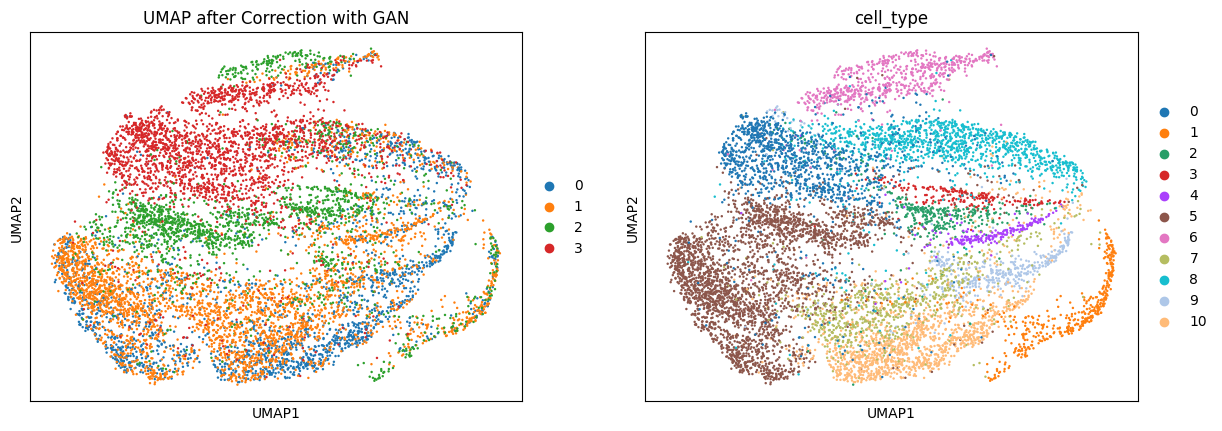

In [48]:
sc.pp.neighbors(adata, use_rep='X_emb')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch', 'cell_type'], title="UMAP after Correction with GAN")  # 观察批次效应是否减少

上面的方法就是去除了批次效应，左侧的标签是批次，右侧的标签是细胞类型，左侧不同的批次混合在一起，右侧细胞聚类也尽可能聚在一起，可以与下面的未去除批次效应相比较

In [49]:
import scanpy as sc
import pandas as pd
import numpy as np
import scanpy as sc
raw_data = pd.read_csv("dataset/DC_pre.csv")
BID_data = np.array(raw_data)
raw_label = pd.read_csv("dataset/DC_celltype.csv")
BID_label = np.array(raw_label)
BID_labels = [int(x) for item in BID_label for x in item] #
raw_batch = pd.read_csv("dataset/DC_batch_1.csv")
BID_batch = np.array(raw_batch)
BID_batches = [int(x) for item in BID_batch for x in item] #
batches = np.array(BID_batches)

data, labels ,csv_batch = BID_data, BID_labels,BID_batches
cell_types = np.array(labels)  # 假设 labels 包含了细胞类型信息
adata = sc.AnnData(data)  # 将原始数据放入X
adata.obs['batch'] = pd.Categorical(batches)  # 批次信息
adata.obs['cell_type'] = pd.Categorical(labels)  # 细胞类型信息


In [50]:
import scanpy as sc
import pandas as pd
import numpy as np
import scanpy as sc
raw_data = pd.read_csv("dataset/Lung_counts.csv")
BID_data = np.array(raw_data)
raw_label = pd.read_csv("dataset/Lung_celltype_codes.csv",usecols=[1])
BID_label = np.array(raw_label)
BID_labels = [int(x) for item in BID_label for x in item]
raw_batch = pd.read_csv("dataset/Lung_batch_codes.csv",usecols=[1])
BID_batch = np.array(raw_batch)
BID_batches = [int(x) for item in BID_batch for x in item]
batches = np.array(BID_batches)

data, labels ,csv_batch = BID_data, BID_labels,BID_batches
cell_types = np.array(labels)  # 假设 labels 包含了细胞类型信息
adata = sc.AnnData(data)  # 将原始数据放入X
adata.obs['batch'] = pd.Categorical(batches)  # 批次信息
adata.obs['cell_type'] = pd.Categorical(labels)  # 细胞类型信息


In [51]:
adata

AnnData object with n_obs × n_vars = 9701 × 1000
    obs: 'batch', 'cell_type'

In [52]:
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors=10,n_pcs=25)

In [53]:
sc.tl.umap(adata)

In [54]:
!pip3 install igraph
!pip3 install leidenalg

In [55]:
sc.tl.leiden(adata)

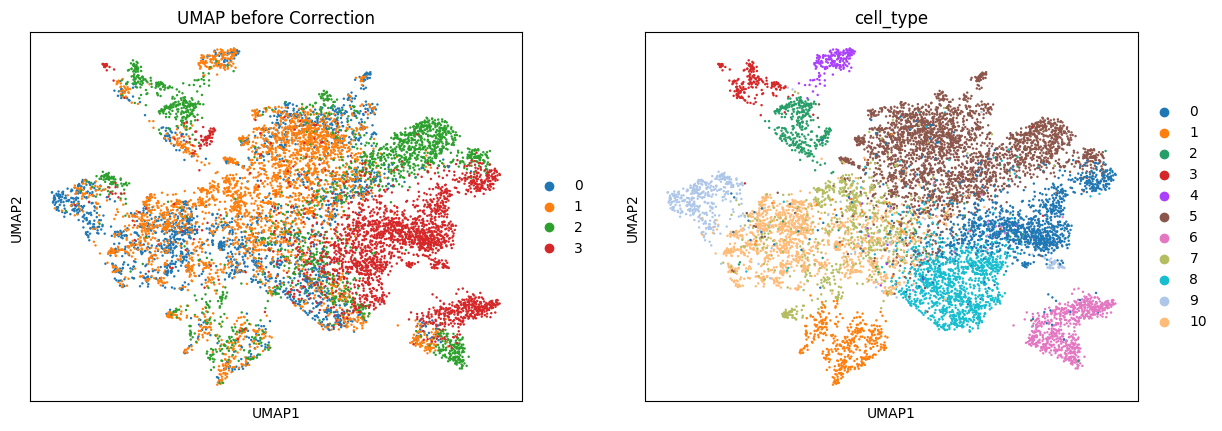

In [56]:
sc.pl.umap(adata, color=['batch', 'cell_type'], title="UMAP before Correction")